In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from kinetic_function import (fit_function,
                              read_csv_file, 
                              single_track_analysis,
                              autocorrelation,
                              fit_autocorrelation,
                             )

In [44]:
PROTEIN_SIZE = 1200
DELTA_T = 0.39

In [27]:
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/"
files = [
        "trackCyril_0_mean_intensity.csv",
]


# Single track analysis

In [28]:
# datas = read_csv_file(path+files[0])
datas = pd.read_csv(path+files[0]).T
datas.drop(index=["Frame number"], inplace=True)

In [29]:
# print(np.unique(datas.TRACK_ID))
datas.head()

,0,1,2,3,4,5,6,7,8,9,...,570,571,572,573,574,575,576,577,578,579
mhtTracks-Run1#0,376.833333,470.657143,240.371795,360.805556,149.692308,117.897436,538.119048,310.846154,113.200000,-52.283333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mhtTracks-Run1#1,330.383333,375.750000,394.833333,449.444444,297.100000,356.583333,42.226190,12.329365,-67.710317,341.683992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mhtTracks-Run1#2,311.626068,894.031746,28.259875,401.896050,-69.128205,-120.564103,-369.384615,-226.897436,614.023923,65.301619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mhtTracks-Run1#3,402.914286,673.387560,440.416667,734.000000,309.315789,525.452991,1211.630952,1313.150794,1500.568421,1105.191667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mhtTracks-Run1#4,NaN,632.222222,537.666667,735.070513,491.721053,259.222222,-117.343434,-51.452020,-98.270202,-59.883838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
tracks = []
for i, val in datas.iterrows():
    if (len(val.to_numpy()[~np.isnan(val.to_numpy())])) > 80:
        print(i)
        tracks.append(i)

mhtTracks-Run1#7
mhtTracks-Run1#47
mhtTracks-Run1#99
mhtTracks-Run1#100
mhtTracks-Run1#112
mhtTracks-Run1#120
mhtTracks-Run1#133
mhtTracks-Run1#158
mhtTracks-Run1#166
mhtTracks-Run1#171
mhtTracks-Run1#185
mhtTracks-Run1#209
mhtTracks-Run1#223
mhtTracks-Run1#245


In [134]:
import multipletau
from scipy import optimize

def fit_autocorrelation2(x, y, func_=fit_function, method='lm', protein_size=1500):
    """
    Fit autocorrelation curve with func_
    Parameters
    ----------
    x, y: x and y values of autocorrelation curve
    func_  : function to fit
    method : method of fit resolution
    protein_size: in aa in order to calculation the elongation rate
    """

    popt, pcov = optimize.curve_fit(
        func_,
        x[1:],
        y[1:],
        method=method)

    elongation_r = protein_size / popt[0]
    translation_init_r = popt[1]

    return elongation_r, translation_init_r

def autocorrelation2(y, delta_t=0.5, normalize=True):
    """
    Perform auto correlation

    Parameters
    ----------
    y : intensity signal
    delta_t : time between two images
    normalize : default True

    """
    mm = int(len(y) / 2 - 1)
    if (mm % 2) == 0:
        autocor = multipletau.autocorrelate(
            y,
#             m=mm,
#             deltat=delta_t,
            normalize=normalize
        )
    else:
        autocor = multipletau.autocorrelate(
            y,
#             m=mm + 1,
#             deltat=delta_t,
            normalize=normalize
        )

    return autocor.flatten()[0::2], autocor.flatten()[1::2]

def single_track_analysis(datas, 
                          id_track=0, 
                          delta_t=0.5, 
                          protein_size=1500, 
                          normalise_intensity=2 ** 16 * 100):
    
    y = datas.loc[id_track].values
    y = y[~np.isnan(y)]
    
    x = np.arange(len(y))*delta_t
    
    x_auto, y_auto = autocorrelation2(y, delta_t, True)
    
    elongation_r, translation_init_r = fit_autocorrelation2(x_auto, y_auto, fit_function, protein_size=protein_size)

    return x, y, x_auto, y_auto, elongation_r, translation_init_r

In [135]:
id_track = "mhtTracks-Run1#100"
x, y, x_auto, y_auto, elongation_r, translation_init_r = single_track_analysis(datas, 
                                                                               id_track, 
                                                                               delta_t = 5,
                                                                               protein_size=PROTEIN_SIZE,
                                                                               normalise_intensity=1)
print(elongation_r, translation_init_r)

1064.9418746705253 1.0


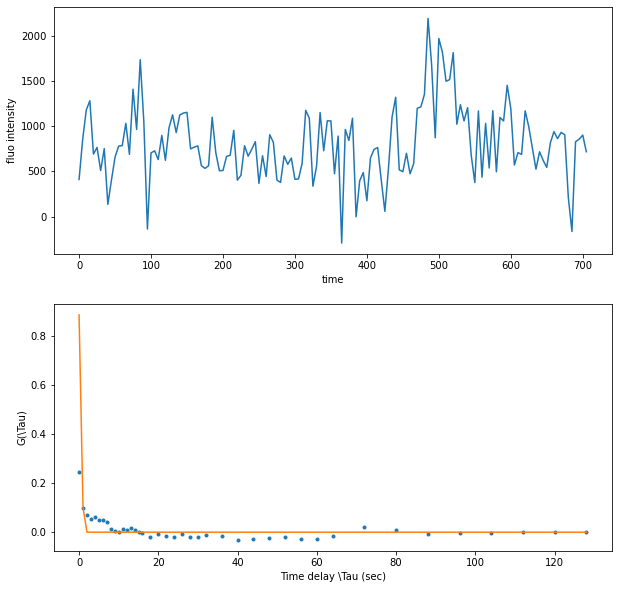

In [136]:
fig, ax = plt.subplots(2,1)
ax[0].plot(x,y)
ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")

ax[1].plot(x_auto, y_auto, '.')
ax[1].plot(x_auto, fit_function(x_auto, PROTEIN_SIZE/elongation_r, translation_init_r) )
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")
fig.set_size_inches((10,10))

# plot all track that was keep in result table

In [10]:
columns = ['track_id','len_track', 'elongation_time', 'init_translation_rate', 'decorr_time']
result = pd.DataFrame(columns=columns, dtype=float)
elongation_time=[]
translation_rate=[]


# tracks = [
#     "mhtTracks-Run1#100",
#     "mhtTracks-Run1#120",
#     "mhtTracks-Run1#133",
#     "mhtTracks-Run1#158",
#     "mhtTracks-Run1#171",
#     "mhtTracks-Run1#185",
#     "mhtTracks-Run1#209",
#     "mhtTracks-Run1#223",
#     "mhtTracks-Run1#245",
# ]

for id_track in tracks:
    x, y, x_auto, y_auto, elongation_r, translation_init_r = single_track_analysis(datas, 
                                                                               id_track, 
                                                                               delta_t = DELTA_T,
                                                                               protein_size=PROTEIN_SIZE)
#     print(PROTEIN_SIZE/elongation_r)
    if (PROTEIN_SIZE/elongation_r)>4:
        d = pd.DataFrame.from_dict({
                                    'track_id':id_track,
                                    'len_track': len(x),
                                    'elongation_time':elongation_r,
                                    'init_translation_rate':translation_init_r,
                                    'decorr_time': PROTEIN_SIZE/elongation_r},
                                   orient='index').T
        result = pd.concat([result, d], ignore_index=True)


# result['tmp'] = 1

In [11]:
result

,track_id,len_track,elongation_time,init_translation_rate,decorr_time
0,mhtTracks-Run1#7,96,219.780285,1.952254,5.459998
1,mhtTracks-Run1#133,149,282.507204,2.8099,4.247679
2,mhtTracks-Run1#158,107,253.027463,1.91314,4.742568
3,mhtTracks-Run1#185,118,263.370455,1.961485,4.55632
4,mhtTracks-Run1#245,158,288.236038,1.426697,4.163255


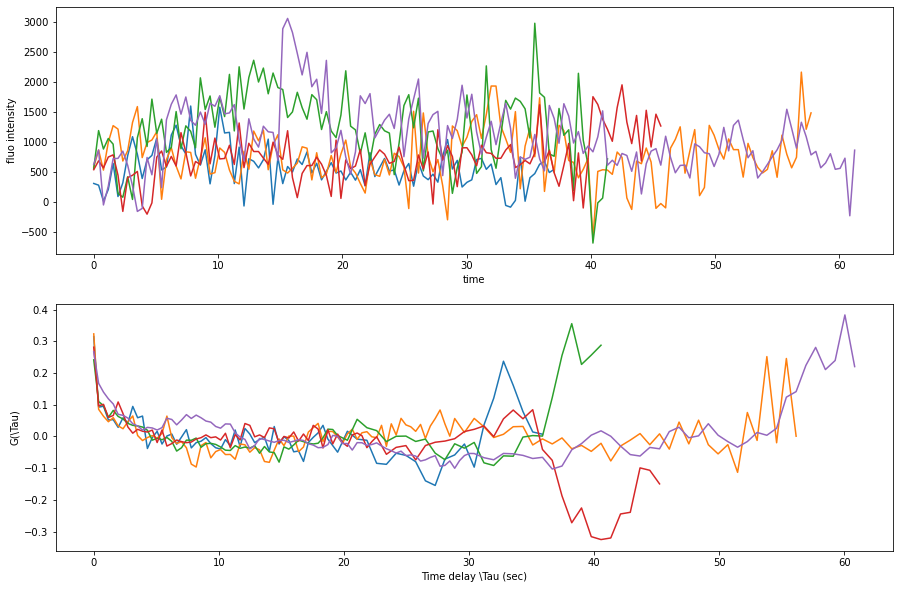

In [50]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(2,1)

colors = list(mcolors.TABLEAU_COLORS.keys())

i=0
# for id_track in tracks:
for id_track in result["track_id"]:


    x, y, x_auto, y_auto, elongation_r, translation_init_r = single_track_analysis(datas, 
                                                                               id_track, 
                                                                               delta_t = DELTA_T,
                                                                               protein_size=PROTEIN_SIZE)

    ax[0].plot(x, y, color=colors[i])
    ax[1].plot(x_auto,#-PROTEIN_SIZE/elongation_r, 
               y_auto, 
               '-', 
               color=colors[i])
#     ax[1].plot(x_auto,#-PROTEIN_SIZE/elongation_r, 
#                fit_function(x_auto, PROTEIN_SIZE/elongation_r, translation_init_r ), 
#                color=colors[i] )
    
    
    
    if i == 7:
        i=0
    else:
        i+=1

ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")
# ax[1].set_xlim((1,20))
# ax[1].set_ylim((-0.1,0.2))
# ax[1].hlines(0, 0, 20, color='grey')


fig.set_size_inches((15,10))

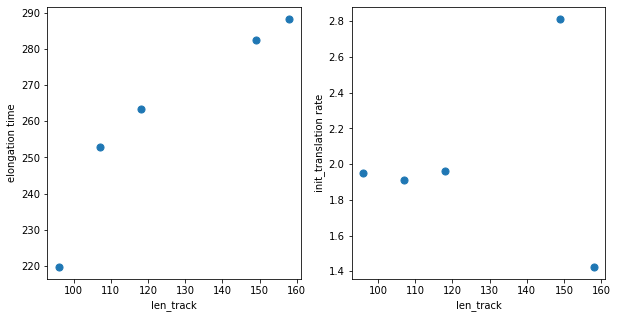

In [13]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(result['len_track'], result['elongation_time'], s=50)
ax[1].scatter(result['len_track'], result['init_translation_rate'], s=50)
ax[0].set_xlabel('len_track')
ax[0].set_ylabel('elongation time')

ax[1].set_xlabel('len_track')
ax[1].set_ylabel('init_translation rate')
fig.set_size_inches((10,5))

len_track                125.600000
elongation_time          261.384289
init_translation_rate      2.012695
decorr_time                4.633964
dtype: float64


/tmp/ipykernel_132999/2862878632.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(result.mean())


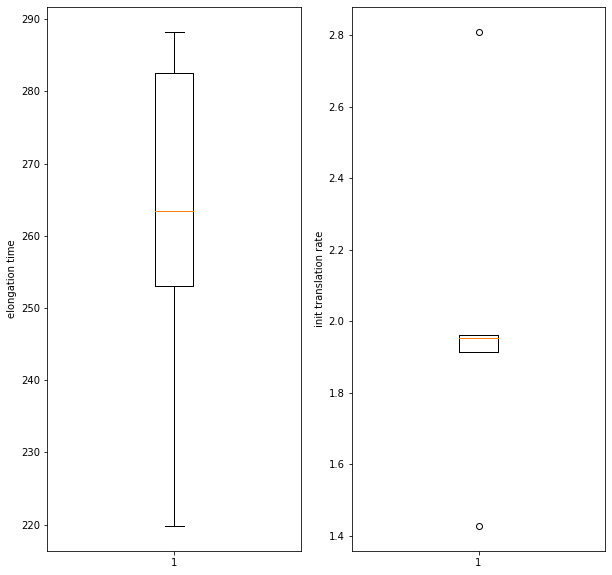

In [14]:
fig, ax = plt.subplots(1, 2)
ax[0].boxplot(result['elongation_time'])
ax[1].boxplot(result['init_translation_rate'])
ax[0].set_ylabel('elongation time')
ax[1].set_ylabel('init translation rate')
fig.set_size_inches((10,10))
print(result.mean())

0.15695798023206262

0.03259387056816391
0.9634752899222976


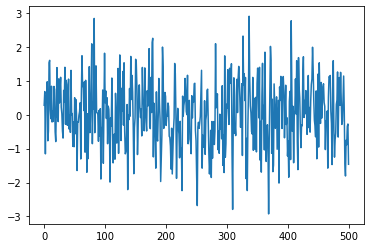

In [65]:
import numpy as np

def sample_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]

# Examples.
sig = sample_signal(500, 0.2)
plt.plot(sig)

print(compute_corr_lag_1(sig))

x_auto, y_auto = autocorrelation(sig, 1, True)

elongation_r, translation_init_r = fit_autocorrelation(x_auto, y_auto, fit_function, protein_size=PROTEIN_SIZE)

    
print()
print(np.mean(sig ))
print(np.std(sig))

In [67]:
PROTEIN_SIZE/elongation_r

44.485175694741805

In [68]:
translation_init_r

0.0010020235757852167

# Multiple file analysis

In [44]:
columns = ['file_name', 'track_id','len_track', 'elongation_time', 'init_translation_rate']
result = pd.DataFrame(columns=columns, dtype=float)
elongation_time=[]
translation_rate=[]
for f in files:
    f = path+f
    datas = read_csv_file(f)


    for id_track in np.unique(datas['TRACK_ID']):
        x, y, x_auto, y_auto, elongation_r, translation_init_r = single_track_analysis(datas, 
                                                                               id_track, 
                                                                               delta_t = DELTA_T,
                                                                               protein_size=PROTEIN_SIZE)
        
        
        if PROTEIN_SIZE/elongation_r>5:
            d = pd.DataFrame.from_dict({'file_name':f.split('/')[-1],
                                        'track_id':id_,
                                        'len_track': len(x)*DELTA_T,
                                        'elongation_time':elongation_r,
                                        'init_translation_rate':translation_init_r},
                                       orient='index').T
            result = pd.concat([result, d], ignore_index=True)



result['tmp'] = 1
# result.drop(result[result["len_track"]<100].index, inplace=True)

In [45]:
# result.sort_values('len_track')
result

,file_name,track_id,len_track,elongation_time,init_translation_rate,tmp
0,Snail CT 061222 E1_1_track.csv,59,197.34,33.42699,98.256678,1
1,Snail CT 061222 E1_1_track.csv,59,166.14,29.701161,65.710959,1
2,Snail CT 061222 E1_1_track.csv,59,166.14,36.831572,207.141304,1
3,Snail CT 061222 E1_2_track.csv,59,191.88,58.710773,506.608097,1
4,Snail CT 061222 E1_2_track.csv,59,197.73,22.893019,60.078082,1
5,Snail CT 061222 E1_2_track.csv,59,154.44,28.489457,181.953198,1
6,Snail CT 061222 E1_2_track.csv,59,156.0,29.626129,29.620264,1
7,Snail CT 061222 E1_2_track.csv,59,169.65,55.250952,69.282469,1
8,Snail CT 061222 E1_3_track.csv,59,190.71,56.901926,299.749511,1
9,Snail CT 061222 E1_3_track.csv,59,198.51,19.493409,93.64649,1


track_id                  59.000000
len_track                158.632500
elongation_time           67.080451
init_translation_rate    352.914693
tmp                        1.000000
dtype: float64


/tmp/ipykernel_72741/2862878632.py:7: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



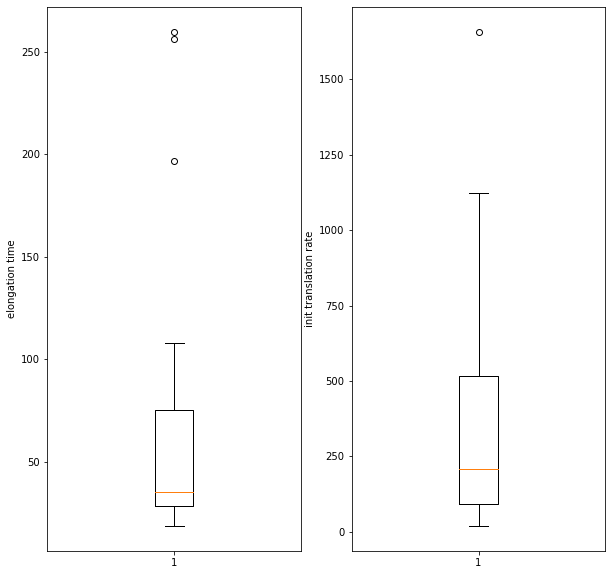

In [46]:
fig, ax = plt.subplots(1, 2)
ax[0].boxplot(result['elongation_time'])
ax[1].boxplot(result['init_translation_rate'])
ax[0].set_ylabel('elongation time')
ax[1].set_ylabel('init translation rate')
fig.set_size_inches((10,10))
print(result.mean())

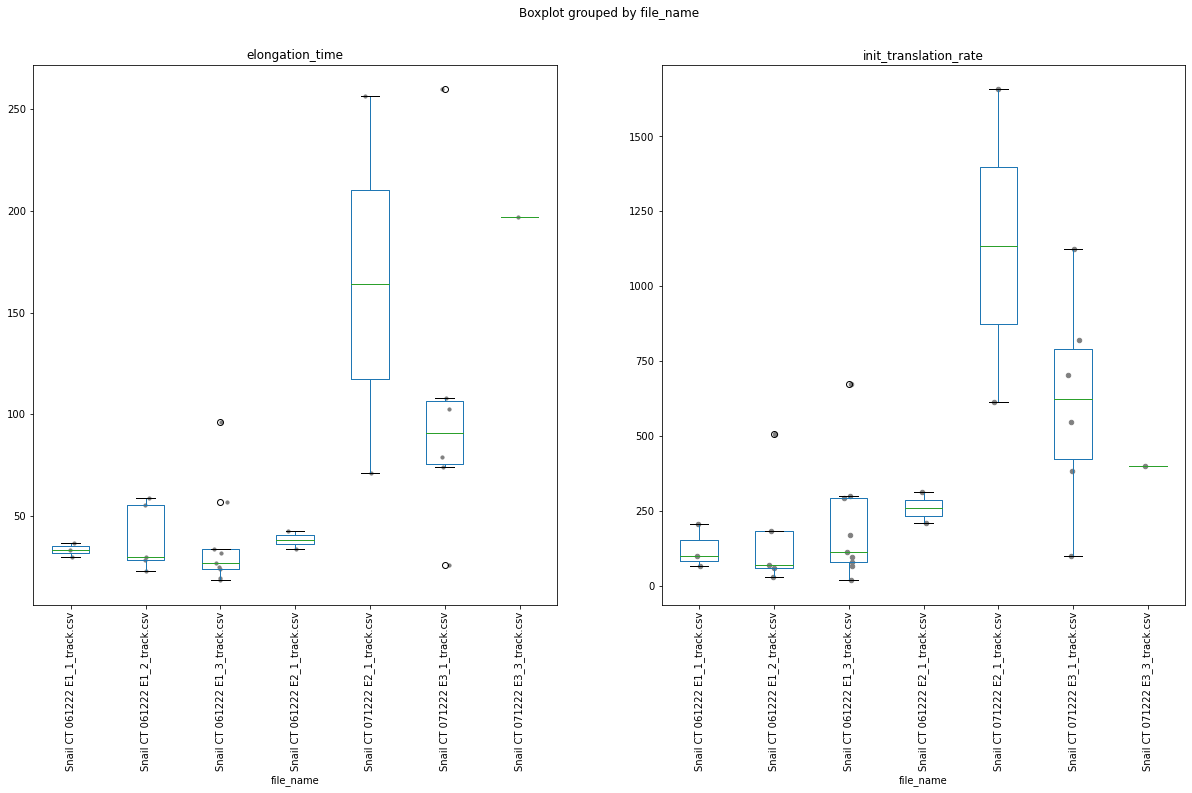

In [48]:
# result['elongation_time'] = pd.to_numeric(result['elongation_time'])
fig, ax = plt.subplots(1,2)
result.boxplot(['elongation_time'] , 
               by='file_name', 
               grid=False, 
               ax = ax[0],
               rot=90, 
              )

result.boxplot([ 'init_translation_rate'] , 
               by='file_name', 
               grid=False, 
               ax = ax[1],
               rot=90
               )

group = 'file_name'
column = 'elongation_time'
grouped = result.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[0].scatter(x, val, c='grey', alpha=1, s=10)
    
    
group = 'file_name'
column = 'init_translation_rate'
grouped = result.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[1].scatter(x, val, c='grey', alpha=1, s=20)
    
# ax[1].set_ylim(0,250)
fig.set_size_inches((20,10))

In [62]:
result.groupby(by='file_name')[['len_track','elongation_time', 'init_translation_rate']].mean()

,len_track,elongation_time,init_translation_rate
file_name,,,
Snail CT 061222 E1_1_track.csv,176.540000,33.319908,123.702980
Snail CT 061222 E1_2_track.csv,173.940000,38.994066,169.508422
Snail CT 061222 E1_3_track.csv,183.516667,36.934602,199.970301
Snail CT 061222 E2_1_track.csv,196.755000,38.287813,259.472344
Snail CT 071222 E2_1_track.csv,57.330000,163.791299,1135.686527
Snail CT 071222 E3_1_track.csv,131.625000,108.293632,612.276570
Snail CT 071222 E3_3_track.csv,92.820000,196.991156,399.250485


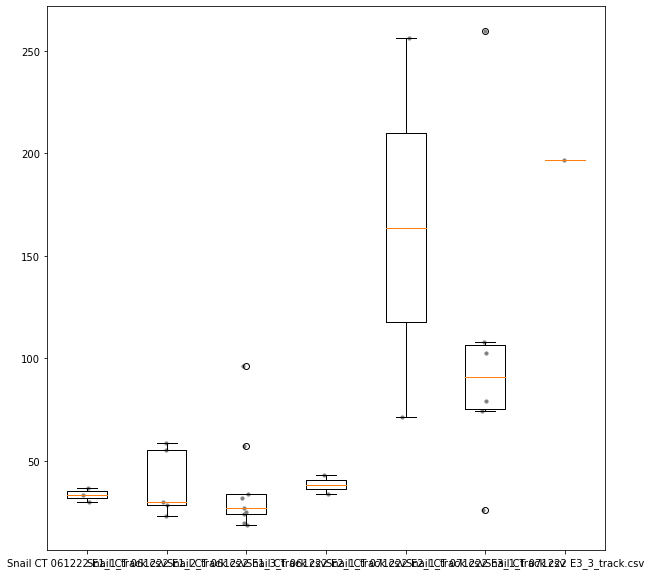

In [56]:
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# initialize dataframe
# n = 200
# ngroup = 3
# df = pd.DataFrame({'data': np.random.rand(n), 'group': map(np.floor, np.random.rand(n) * ngroup)})
fig, ax = plt.subplots()

group = 'file_name'
column = 'elongation_time'
grouped = result.groupby(group)

names, vals, xs = [], [] ,[]

for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

ax.boxplot(vals, labels=names, )
ngroup = len(vals)



for x, val, clevel in zip(xs, vals, clevels):
    ax.scatter(x, val, c='grey', alpha=1, s=10)
    
ax.grid(False)
fig.set_size_inches((10,10))

In [58]:
result[["file_name", 'len_track','elongation_time', 'init_translation_rate']]

,file_name,len_track,elongation_time,init_translation_rate
0,Snail CT 061222 E1_1_track.csv,197.34,33.42699,98.256678
1,Snail CT 061222 E1_1_track.csv,166.14,29.701161,65.710959
2,Snail CT 061222 E1_1_track.csv,166.14,36.831572,207.141304
3,Snail CT 061222 E1_2_track.csv,191.88,58.710773,506.608097
4,Snail CT 061222 E1_2_track.csv,197.73,22.893019,60.078082
5,Snail CT 061222 E1_2_track.csv,154.44,28.489457,181.953198
6,Snail CT 061222 E1_2_track.csv,156.0,29.626129,29.620264
7,Snail CT 061222 E1_2_track.csv,169.65,55.250952,69.282469
8,Snail CT 061222 E1_3_track.csv,190.71,56.901926,299.749511
9,Snail CT 061222 E1_3_track.csv,198.51,19.493409,93.64649


In [215]:
result[["file_name", 'len_track','elongation_time_norm', 'init_translation_rate']].mean()

/tmp/ipykernel_111383/2480877291.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result[["file_name", 'len_track','elongation_time_norm', 'init_translation_rate']].mean()


len_track                176.642143
elongation_time_norm      41.779666
init_translation_rate      0.753582
dtype: float64

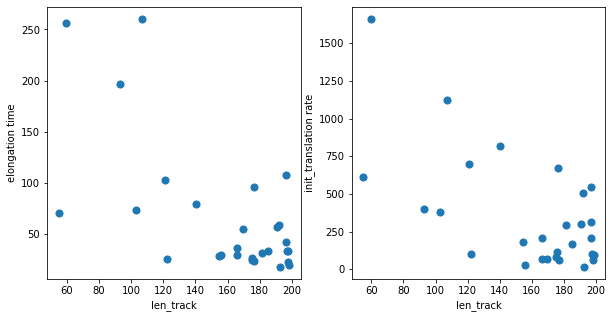

In [63]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(result['len_track'], result['elongation_time'], s=50)
ax[1].scatter(result['len_track'], result['init_translation_rate'], s=50)
ax[0].set_xlabel('len_track')
ax[0].set_ylabel('elongation time')

ax[1].set_xlabel('len_track')
ax[1].set_ylabel('init_translation rate')
fig.set_size_inches((10,5))